In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from textblob import TextBlob

import spacy
import scipy as sp

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_colwidth', None)

nltk.download('wordnet')
nltk.download('stopwords')

import texthero as hero

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aoxiangsuen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aoxiangsuen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('train.csv')

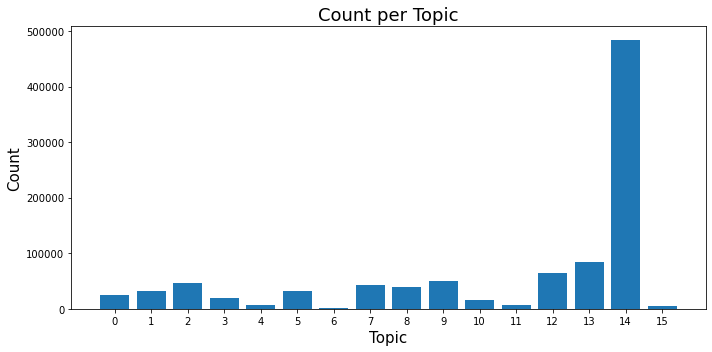

In [36]:
count = df.groupby(['Outcome']).count().Text

fig = plt.figure(figsize=(10,5))
plt.bar(range(len(count)), count.values)
plt.xticks(range(len(count)), count.index)
plt.xlabel('Topic', size = 15)
plt.ylabel('Count', size=15)
plt.title('Count per Topic', size=18)
plt.tight_layout()
plt.show()
fig.savefig('count.png', pad_inches = 100, dpi=300)

In [4]:
count

Outcome
0      24428
1      31270
2      47268
3      20200
4       6108
5      32702
6       2328
7      42518
8      38590
9      49192
10     16062
11      7168
12     64990
13     83464
14    483982
15      5184
Name: Text, dtype: int64

# Feature Engineering

### Features from counting operations

In [274]:
def count_symbols(text):
    pattern = r'[{}]'.format(string.punctuation)
    count_sym = len(re.findall(pattern, text))
    return count_sym

def count_numbers(text):
    count_num = len(re.findall(r'\d+', text))
    return count_num

def count_mathexp(text):
    pattern = r"(\$+)(?:(?!\1)[\s\S])*\1"
    count_mathexp = len(re.findall(pattern ,text))
    return count_mathexp

def engineer_features(df):
    
    df['symbol_count'] = df.Text.apply(lambda x: count_symbols(x))
    df['number_count'] = df.Text.apply(lambda x: count_numbers(x))
    df['mathexp_count'] = df.Text.apply(lambda x: count_mathexp(x))
    df['word_count'] = df.Text.apply(lambda x: len(str(x).split(" ")))
    df['char_count'] = df.Text.apply(lambda x: sum(len(word) for word in str(x).split(" ")))
    df['sentence_count'] = df.Text.apply(lambda x: len(str(x).split(".")))
    df['avg_word_length'] = df['char_count'] / df['word_count']
    df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
    df['sentiment'] = df.Text.apply(lambda x: (TextBlob(x).sentiment.polarity + 1) / 2)
    
    return df

manual_col = ['symbol_count', 'number_count', 'mathexp_count', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_length', 'sentiment']

df = engineer_features(df)

### Features from Entity Recognition

In [275]:
ner = spacy.load("en_core_web_lg")
ner_col = ['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART']

def tag_ner(text):
    regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
    result = re.sub(regex, '', text)
    lst = [(tag.label_) for tag in ner(result).ents]
    count = [lst.count(tag) for tag in lst]
    dic = dict(zip(lst, count))
    return dic

df = df.reindex(columns = df.columns.tolist() + ner_col).fillna(0)
df['tags'] = df.Text.apply(lambda x: tag_ner(x))
for col in ner_col:
    df[col] = df.tags.apply(lambda x: x[col] if col in x.keys() else 0)


# Text Preprocessing

In [1032]:
import unicodedata

stop_words = stopwords.words('english')

def remove_weblinks(text):
    new_text = re.sub('http[s]?://\S+', '', text)
    return new_text

def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

def remove_non_alphabets(text):
    pattern = r'[^a-zA-Z]+'
    return re.sub(pattern, ' ', text)

def lowercase(text):
    return text.lower()

def remove_short_words(text):
    new_text = text.split()
    new_text = [word for word in new_text if len(word) >= 3]
    new_text = ' '.join(new_text)
    return new_text

def remove_stopwords(text):
    new_text = text.split()
    new_text = [word for word in new_text if word not in stop_words]
    new_text = ' '.join(new_text)
    return new_text

def stemming(text):
    porter_stemmer = PorterStemmer()
    new_text = text.split()
    new_text = [porter_stemmer.stem(word=w) for w in new_text]
    new_text = ' '.join(new_text)
    return new_text

def preprocess(text):
    
    text = remove_accented_chars(text)
    text = remove_weblinks(text)
    text = remove_non_alphabets(text)
    text = lowercase(text)
    text = remove_stopwords(text)
    text = stemming(text)
    text = remove_short_words(text)
    
    return text

### Save preprocessed texts and features from Train and Test sets

In [1035]:
# train set
df['cleaned_text'] = df['Text'].apply(lambda x: preprocess(x))
df.drop('Text', axis=1).to_csv('train_all_features.csv', index=False)

# test set
df_test = pd.read_csv('test.csv')
df_test = engineer_features(df_test)
df_test = df_test.reindex(columns = df_test.columns.tolist() + ner_col).fillna(0)
df_test['tags'] = df_test.Text.apply(lambda x: tag_ner(x))
for col in ner_col:
    df_test[col] = df_test.tags.apply(lambda x: x[col] if col in x.keys() else 0)

df_test['cleaned_text'] = df_test['Text'].apply(lambda x: preprocess(x))
df_test.drop('Text', axis=1).to_csv('test_all_features.csv', index=False)

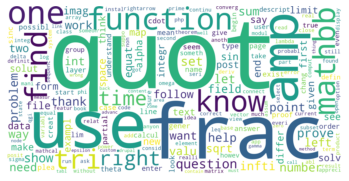

In [39]:
from wordcloud import WordCloud

# visualise processed texts with word cloud

df_train_all_features = pd.read_csv('train_all_features.csv')
df_train_all_features.fillna(value='na', inplace=True)

fig = plt.figure()
string = (" ").join(df_train_all_features.cleaned_text.values.tolist())
wordcloud = WordCloud(background_color='white', collocations=False, width=2000, height=1000).generate(string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
fig.savefig('wordcloud.png', dpi=300)

# Train/Validation Split

In [22]:
# Split train/validation set
df_train_all_features = pd.read_csv('train_all_features.csv')
df_train_all_features.fillna(value='na', inplace=True)
X = df_train_all_features.drop(['Outcome'], axis=1)
y = df_train_all_features['Outcome']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

In [23]:
# save train/validation set to run TextCNN on google colab TPU
X_train.to_csv('Colab Data/X_train.csv')
X_val.to_csv('Colab Data/X_val.csv')
y_train.to_csv('Colab Data/y_train.csv')
y_val.to_csv('Colab Data/y_val.csv')

# Feature Engineering on Train Set (Topic Modelling)

In [1299]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

In [1300]:
X_train_bs = X_train.cleaned_text
y_train_bs = y_train.copy()

In [1040]:
# Sample each class equally to avoid majority class dominating topics in the lda model

from sklearn.utils import resample

df_merge = pd.merge(X_train_bs, y_train_bs, left_index=True, right_index=True)

df_bootstrap = pd.DataFrame(columns = ['cleaned_text', 'Outcome'])
for i in np.unique(df_merge.Outcome):
    df_temp = df_merge[df_merge.Outcome == i]
    bootstrap = resample(df_temp, replace=True, n_samples=10000, random_state=1)
    df_bootstrap = pd.concat([df_bootstrap, bootstrap], axis=0)
    
X_train_bs = df_bootstrap.cleaned_text
y_train_bs = df_bootstrap.Outcome

In [1041]:
X_train_tm = X_train_bs.apply(lambda x: x.split())

In [1042]:
# Create Dictionary
id2word = corpora.Dictionary(X_train_tm.values)

# Create Corpus
texts = X_train_tm.values

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [1043]:
# Build LDA model
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=20, 
                                                    random_state=5153,
                                                    workers = 7,
                                                    passes=15)
lda_model.save('lda_model.model')

In [1044]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=X_train_tm.values, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.621199741524173

Coherence Score:  0.5735929446034644


In [1045]:
# Make corpus for train and val sets
X_train_corpus = X_train.cleaned_text.apply(lambda x: x.split())
X_val_corpus = X_val.cleaned_text.apply(lambda x: x.split())

# Create Corpus
texts_train = X_train_corpus.values
texts_val = X_val_corpus.values

# Term Document Frequency
corpus_train = [id2word.doc2bow(text) for text in texts_train]
corpus_val = [id2word.doc2bow(text) for text in texts_val]

In [1046]:
# get document topics
topics_train = list(lda_model.get_document_topics(corpus_train, minimum_probability=0))
topics_val = list(lda_model.get_document_topics(corpus_val, minimum_probability=0))

In [1295]:
# Reformat topics output into dataframe

def topics_dataframe(topics, X):
    lst = []
    for i in range(len(topics)):
        row = list(map(lambda x: x[1], topics[i]))
        lst.append(row)
    df = pd.DataFrame(lst, index=X.index)
    return df

In [1103]:
topics_train_df = topics_dataframe(topics_train, X_train)
topics_val_df = topics_dataframe(topics_val, X_val)

In [1105]:
# apply lda model on test set
df_test = pd.read_csv('test_all_features.csv', index_col=['Id'])
df_test.fillna(value='na', inplace=True)
X_test_corpus = df_test.cleaned_text.apply(lambda x: x.split())
id2word_test = corpora.Dictionary(X_test_corpus.values)
texts_test = X_test_corpus.values
corpus_test = [id2word.doc2bow(text) for text in texts_test]
topics_test = list(lda_model.get_document_topics(corpus_test, minimum_probability=0))
topics_test_df = topics_dataframe(topics_test, df_test)

### Aggregate manual features

In [25]:
# Get manual columns
topic_col = topics_train_df.columns
X_train_manual = pd.concat([X_train.loc[:, manual_col+ner_col], topics_train_df], axis=1, ignore_index=True)
X_val_manual = pd.concat([X_val.loc[:, manual_col+ner_col], topics_val_df], axis=1, ignore_index=True)

## MultinomialNB

In [26]:
# Get cleaned_text
X_train_text = X_train.loc[:, 'cleaned_text']
X_val_text = X_val.loc[:, 'cleaned_text']

In [27]:
# Convert text into features using tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=10, ngram_range = (1,3), stop_words='english')
X_train_dtm = tfidf_vectorizer.fit_transform(X_train_text)
X_val_dtm = tfidf_vectorizer.transform(X_val_text)

In [1254]:
# add engineered features
X_train_manual_sparse = sp.sparse.csr_matrix(X_train_manual)
X_val_manual_sparse = sp.sparse.csr_matrix(X_val_manual)

X_train_dtm = sp.sparse.hstack([X_train_dtm, X_train_manual_sparse])
X_val_dtm = sp.sparse.hstack([X_val_dtm, X_val_manual_sparse])

In [1255]:
from sklearn.feature_selection import VarianceThreshold

# reduce dimensions by eliminating features with very low variance
selector = VarianceThreshold(threshold = 0.000001)
X_train_dtm_reduced = selector.fit_transform(X_train_dtm)
X_val_dtm_reduced = selector.transform(X_val_dtm)

In [1256]:
print("No. of features before variance reduction:", X_train_dtm.shape[1])
print("No. of features after variance reduction:",X_train_dtm_reduced.shape[1])

No. of features before variance reduction: 281261
No. of features after variance reduction: 152897


In [28]:
# correct imbalanced dataset
df_train = pd.DataFrame(X_train)
df_train['Outcome'] = y_train

count = df_train.groupby(['Outcome']).count().cleaned_text

undersample_strategy = {}
for i in range(len(count)):
    if count[i] >= 150000:
        undersample_strategy[i] = 150000
        
oversample_strategy = {}
for i in range(len(count)):
    if count[i] <= 50000:
        oversample_strategy[i] = 50000
        
under_sampler = RandomUnderSampler(random_state=5153, sampling_strategy=undersample_strategy)
X_train_dtm_resample, y_train_resample = under_sampler.fit_resample(X_train_dtm_reduced, y_train)

over_sampler = SMOTE(random_state=5153, sampling_strategy=oversample_strategy)
X_train_dtm_resample, y_train_resample = over_sampler.fit_resample(X_train_dtm_resample, y_train_resample)

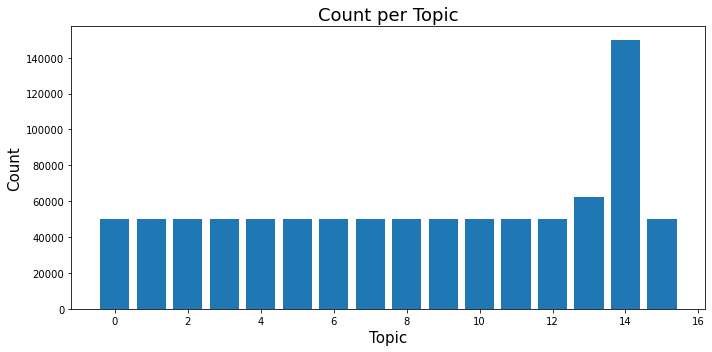

In [34]:
value, count= np.unique(y_train_resample, return_counts=True)

fig = plt.figure(figsize=(10,5))
plt.bar(x = range(16), height=count)
plt.xlabel('Topic', size=15)
plt.ylabel('Count', size=15)
plt.title('Count per Topic', size=18)
plt.tight_layout()
plt.show()
fig.savefig('count_rebalanced.png', pad_inches = 100, dpi=300)

In [1269]:
best_alpha = -1
best_score = -1
for i in np.arange(0.01, 1, 0.01):
    
    # fit model
    nb = MultinomialNB(alpha=i)
    nb.fit(X_train_dtm_resample, y_train_resample)

    # predict
    pred = nb.predict(X_val_dtm_reduced)

    # macro score
    macro_f1_score = f1_score(y_val, pred, average='macro')
    
    if macro_f1_score > best_score:
        best_score = macro_f1_score
        best_alpha = i

print("Best alpha:", best_alpha)
print("Best score:", best_score)

Best alpha: 0.01
Best score: 0.8069427184760931


In [1270]:
# refit model with best alpha

nb = MultinomialNB(alpha=best_alpha)
nb.fit(X_train_dtm_resample, y_train_resample)

# predict
pred = nb.predict(X_val_dtm_reduced)

# macro score
macro_f1_score = f1_score(y_val, pred, average='macro')
print(macro_f1_score)

0.8069427184760931


In [1271]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      6107
           1       0.94      0.93      0.94      7817
           2       0.89      0.87      0.88     11817
           3       0.78      0.86      0.82      5050
           4       0.50      0.86      0.63      1527
           5       0.82      0.90      0.86      8175
           6       0.36      0.73      0.48       582
           7       0.80      0.80      0.80     10630
           8       0.89      0.89      0.89      9648
           9       0.89      0.80      0.84     12298
          10       0.52      0.69      0.59      4015
          11       0.77      0.90      0.83      1792
          12       0.83      0.82      0.82     16248
          13       0.93      0.96      0.95     20866
          14       0.99      0.95      0.97    120996
          15       0.65      0.87      0.74      1296

    accuracy                           0.91    238864
   macro avg       0.78   

In [1277]:
# top important features
sorted(zip(nb.coef_[0], feature_names), reverse=True)[:20]

/Users/aoxiangsuen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


[(-2.8087544819042396, 'money money'),
 (-3.11966027323235, 'money suppli'),
 (-3.4470782385516046, 'money spent'),
 (-4.149776612283759, 'googl account sync'),
 (-4.379601460036806, 'money left'),
 (-4.71905177467694, 'hour howev'),
 (-4.767733626306979, 'mini display'),
 (-4.852789374589915, 'money save'),
 (-4.9303198829058585, 'fuel requir'),
 (-5.033970596803628, 'garag band'),
 (-5.071827133763142, 'button ask'),
 (-5.1074604962123615, 'money got'),
 (-5.1149305376299, 'money possibl'),
 (-5.289675819259394, 'geometri calculu'),
 (-5.303426325407416, 'money pay'),
 (-5.381377313581774, 'articl written'),
 (-5.470680620042832, 'money play'),
 (-5.591415832960994, 'hold visa'),
 (-5.641949776365229, 'got basic'),
 (-5.642446708502918, 'linear transform finit')]

### Text CNN

In [1192]:
# load cnn predicted probabilities from google colab

val_pred_proba_cnn = np.load('val_pred_proba.npy')

### Ensemble Multinomial NB and Text CNN

In [1274]:
best_nb_ratio = -1
best_score = -1

for i in np.arange(0, 1, 0.1):
    val_pred_proba_nb = nb.predict_proba(X_val_dtm_reduced)
    val_pred_proba_avg = (i * val_pred_proba_nb + (1-i) * val_pred_proba_cnn)
    val_pred = np.argmax(val_pred_proba_avg, axis=1)

    # macro score
    macro_f1_score = f1_score(y_val, val_pred, average='macro')
    if macro_f1_score > best_score:
        best_score = macro_f1_score
        best_nb_ratio = i

print("Best nb model ratio:", best_nb_ratio)
print("Best cnn model ratio:", 1-best_nb_ratio)
print("Best score:", best_score)

Best nb model ratio: 0.5
Best cnn model ratio: 0.5
Best score: 0.841913888048778


In [1276]:
# Submission

df_test_all_features = pd.read_csv('test_all_features.csv', index_col=['Id'])
df_test_all_features.fillna(value='na', inplace=True)

# Vectorize
X_test_dtm = tfidf_vectorizer.transform(df_test_all_features.cleaned_text)

# Aggregate manual features
X_test_manual = topics_test_df
X_test_manual_sparse = sp.sparse.csr_matrix(X_test_manual)
X_test_dtm = sp.sparse.hstack([X_test_dtm, X_test_manual_sparse])
X_test_dtm_reduced = selector.transform(X_test_dtm)

# Prediction
test_pred_proba_nb = nb.predict_proba(X_test_dtm_reduced)
test_pred_proba_cnn = np.load('test_pred_proba.npy')
test_pred_proba_avg = (best_nb_ratio * test_pred_proba_nb + (1-best_nb_ratio) * test_pred_proba_cnn)
test_pred = np.argmax(test_pred_proba_avg, axis=1)

df_test_all_features['Outcome'] = test_pred

submission = df_test_all_features[['Outcome']]
submission.to_csv('submission.csv')